In [71]:
pip install autocorrect

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [72]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [73]:
pip install langid

Note: you may need to restart the kernel to use updated packages.


In [74]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [75]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [76]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import seaborn as sns
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from nltk.stem import PorterStemmer
from langdetect import detect
import langid
import contractions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

%matplotlib inline

In [79]:

df = pd.read_csv('/kaggle/input/imdb-dataset/movie.csv', header=0)

In [80]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [81]:
df.shape

(40000, 2)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [83]:
df['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

In [84]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [85]:
# checking the number of rows and columns
rows,columns=df.shape[0],df.shape[1]

In [86]:
# checking for duplicate instances
no_of_duplicates=df.duplicated().sum()

In [87]:
# dropping the duplicate values
df.drop_duplicates(inplace=True)

In [88]:
# checking for NaN values.
no_of_nan_values=df.isna().sum()

In [89]:
df['text_word_count']=df['text'].apply(lambda x:len(x.split()))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


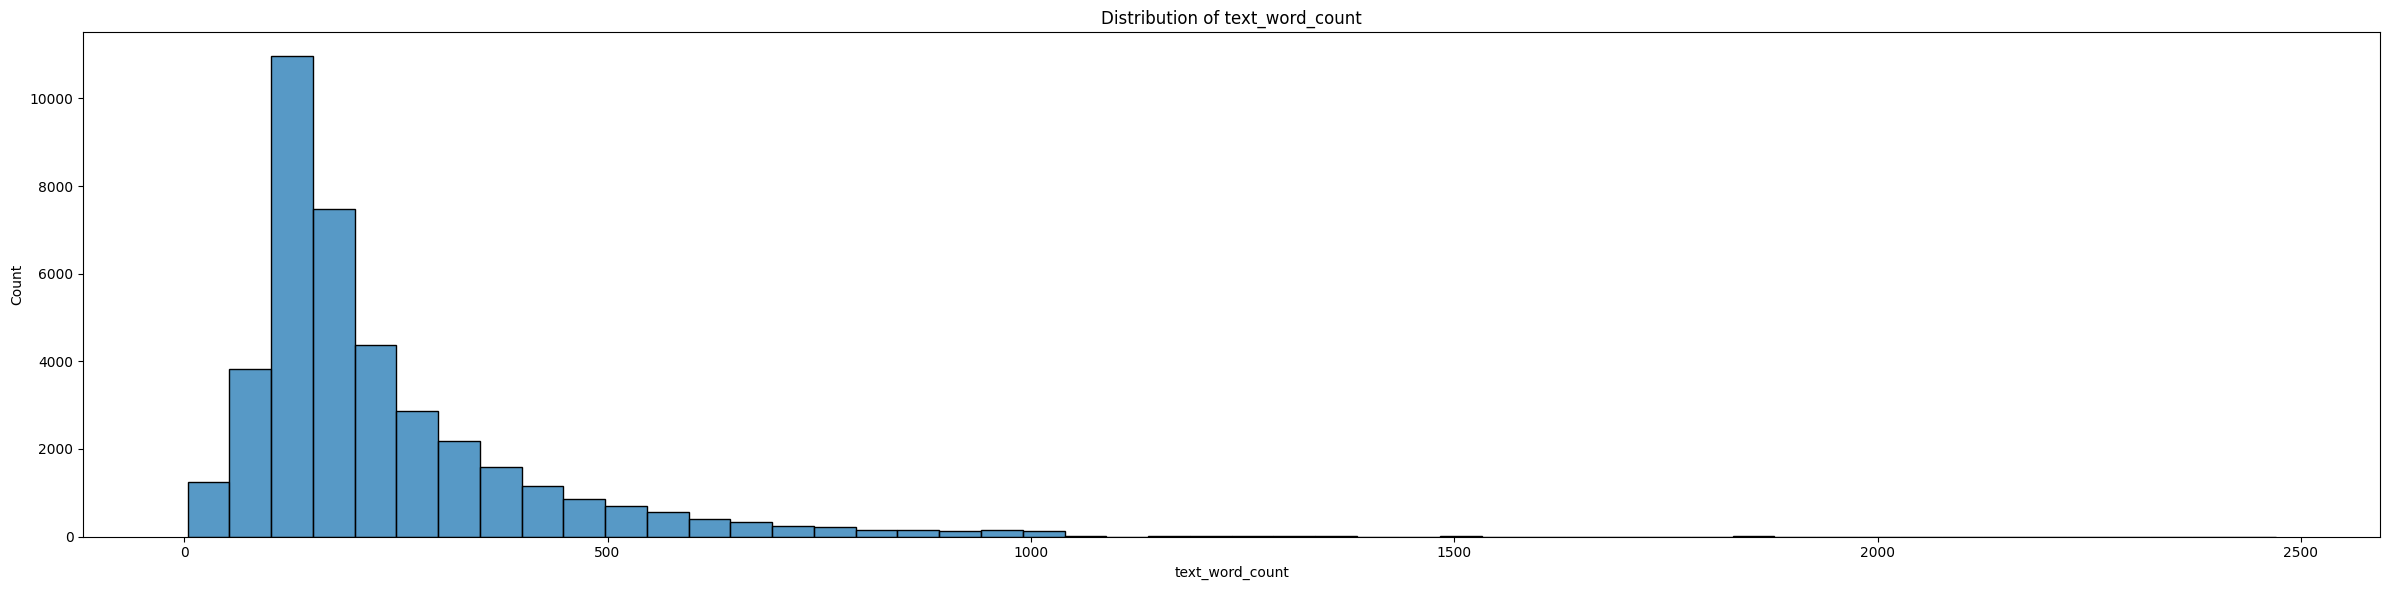

In [90]:

num_cols = ['text_word_count']  # Ensure it's a list even if it's just one column
plt.figure(figsize=(24, 6))

for i, col in enumerate(num_cols):
  #  plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, bins=50)
    plt.title("Distribution of {}".format(col))

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

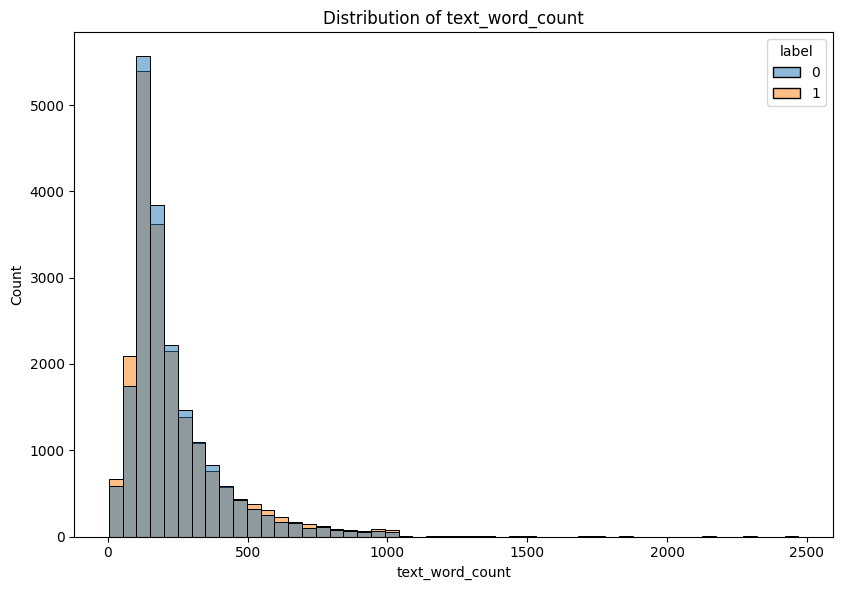

In [91]:
num_cols = ['text_word_count']
plt.figure(figsize=(24,6))
for i,col in enumerate(num_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df,x=col,hue='label',bins=50)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

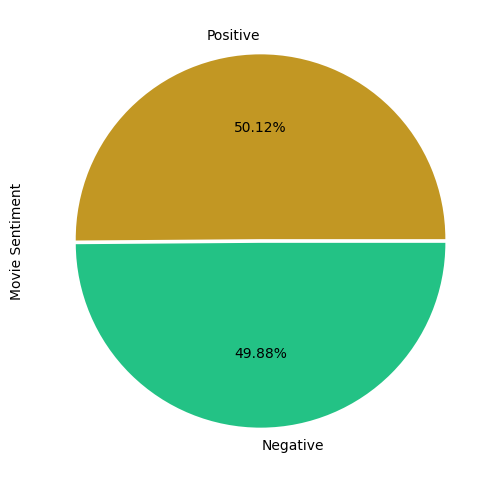

In [92]:

plt.figure(figsize=(10,6))
colors=['#c29723','#23c285']
plt.pie(df['label'].value_counts(),labels=['Positive','Negative'],autopct='%.2f%%',explode=[0.01,0.01],colors=colors);
plt.ylabel('Movie Sentiment');

In [93]:
X= df['text']
y= df['label']

In [94]:
X.head()

0    I grew up (b. 1965) watching and loving the Th...
1    When I put this movie in my DVD player, and sa...
2    Why do people who do not know what a particula...
3    Even though I have great interest in Biblical ...
4    Im a die hard Dads Army fan and nothing will e...
Name: text, dtype: object

In [95]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: label, dtype: int64

In [96]:
X.shape, y.shape

((39723,), (39723,))

### Text Data Preprocessing

In [97]:
import re

def text_cleaning(text):
    # Step 1: Convert text to lowercase
    text = text.lower()

    # Step 2: Remove HTML tags
    text = re.sub(pattern=r'<.*?>', repl='', string=text)

    # Step 3: Remove URLs
    text = re.sub(pattern=r'http\S+|www\S+|ftp\S+', repl='', string=text)

    # Step 4: Remove 'rt'
    text = re.sub(pattern=r' rt', repl='', string=text)

    # Step 5: Remove words starting with '!'
    text = re.sub(pattern=r'!\S+', repl='', string=text)

    # Step 6: Remove mentions starting with '@'
    #text = re.sub(pattern=r'@\S+', repl='', string=text)

    # Step 7: Remove Unicode emojis
    text = re.sub(pattern=r'&#\d+;', repl='', string=text)

    text = re.sub(pattern=r'&amp', repl='', string=text)

    # Step 8: Remove '#' and '$'
    text = re.sub(pattern=r'#|\$', repl='', string=text)

    # Step 9: Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Step 10: Remove numeric digits
    text = re.sub(r'\d+', '', text)

    # Step 11: Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Step 12: Remove single characters
    text = re.sub(r'\b\w\b', '', text)

    # Step 13: Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [98]:
X= X.apply(text_cleaning)

In [99]:
print(type(X))

<class 'pandas.core.series.Series'>


In [100]:
X[:5]

0    grew up watching and loving the thunderbirds a...
1    when put this movie in my dvd player and sat d...
2    why do people who do not know what particular ...
3    even though have great interest in biblical mo...
4    im die hard dads army fan and nothing will eve...
Name: text, dtype: object

Stop word removal

In [101]:
def stopwords_removal(text):
    words= word_tokenize(text)
    stopword= set(stopwords.words('english'))
    filtered_text= [word for word in words if word.lower() not in stopword]
    return ' '.join(filtered_text)

In [102]:
X= X.apply(stopwords_removal)
X[:5]

0    grew watching loving thunderbirds mates school...
1    put movie dvd player sat coke chips expectatio...
2    people know particular time past like feel nee...
3    even though great interest biblical movies bor...
4    im die hard dads army fan nothing ever change ...
Name: text, dtype: object

### Stemming

In [103]:
def stemming(text):
    words= word_tokenize(text)
    stemmer= PorterStemmer()
    stemmed_text= [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_text)

In [104]:
X1= X.apply(stemming)
X1[:5]

0    grew watch love thunderbird mate school watch ...
1    put movi dvd player sat coke chip expect hope ...
2    peopl know particular time past like feel need...
3    even though great interest biblic movi bore de...
4    im die hard dad armi fan noth ever chang got t...
Name: text, dtype: object

In [105]:
### Lemmatization

In [108]:
#def lemmetizing(text):
 #   words= word_tokenize(text)
 # lemmatizer= WordNetLemmatizer()
 #   lemmatized_text= [lemmatizer.lemmatize(word,pos='v') for word in words]
  #  return ' '.join(lemmatized_text)

In [109]:
#X2= X.apply(lemmetizing)

In [110]:
X.head()

0    grew watching loving thunderbirds mates school...
1    put movie dvd player sat coke chips expectatio...
2    people know particular time past like feel nee...
3    even though great interest biblical movies bor...
4    im die hard dads army fan nothing ever change ...
Name: text, dtype: object

In [111]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: label, dtype: int64

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf= TfidfVectorizer()
transformed_tf_idf= tf_idf.fit_transform(X1)

In [115]:
# Assuming tf_idf is your TF-IDF vectorizer
feature_names = tf_idf.get_feature_names_out()

# Display the first 10 items in the vocabulary
print(feature_names[:50])


['aa' 'aaa' 'aaaa' 'aaaaaaaaaaaahhhhhhhhhhhhhh' 'aaaaaaaargh' 'aaaaaaah'
 'aaaaaaahhhhhhggg' 'aaaaagh' 'aaaaah' 'aaaaargh'
 'aaaaarrrrrrgggggghhhhhh' 'aaaaaw' 'aaaahhhhhh' 'aaaahhhhhhh' 'aaaand'
 'aaaggghhhhhhh' 'aaah' 'aaahhhhhhh' 'aaahth' 'aaargh' 'aachen' 'aada'
 'aadha' 'aag' 'aagh' 'aaghh' 'aah' 'aahemi' 'aahhhh' 'aaila' 'aailiyah'
 'aaip' 'aaja' 'aajala' 'aak' 'aakash' 'aaker' 'aalcc' 'aaliyah' 'aalox'
 'aam' 'aamess' 'aamiln' 'aamir' 'aamirso' 'aamr' 'aan' 'aankhen' 'aaoon'
 'aap']


In [116]:
transformed_tf_idf.shape

(39723, 148621)

In [117]:
transformed_tf_idf.toarray()[2,100:200]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [119]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(transformed_tf_idf,y,test_size=0.2)

In [122]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [123]:
y_pred = model.predict(X_test)

In [124]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [125]:
accuracy

0.8590308370044053

In [127]:
### Prediction support

In [130]:
def predict_sentiment(sentence, model, feature_names):
    cleaned_sentence = clean_text(sentence) # clear sentence
    sentence_vectorized = feature_names.transform([cleaned_sentence]).toarray() # vectorize the sentence
    prediction = model.predict(sentence_vectorized) # to predict with use model
    return prediction

### Performance matrix

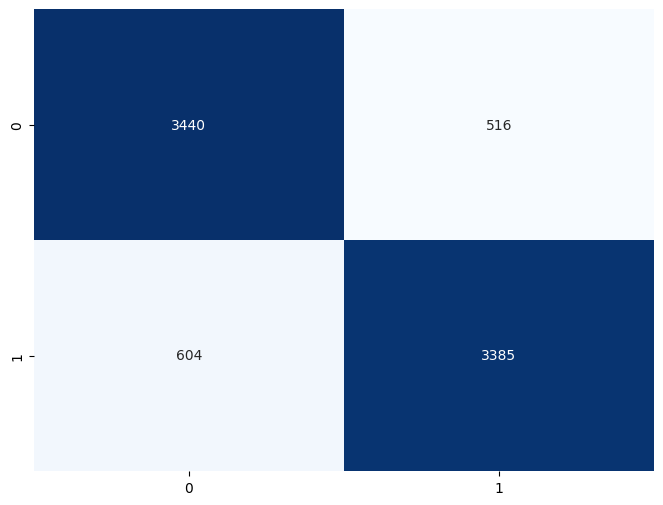

Accuracy: 0.8590308370044053
Rapor:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      3956
           1       0.87      0.85      0.86      3989

    accuracy                           0.86      7945
   macro avg       0.86      0.86      0.86      7945
weighted avg       0.86      0.86      0.86      7945



In [135]:
# Model performansını görselleştirme
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.show()

print("Accuracy:", accuracy)

print(report)